# Normalizing Flows Tutorial
#### David Ruhe

## Variational Inference

Let's start with VAEs. In VAEs we have the following Bayesian network:
$$Z \rightarrow X$$

Here, $X$ is a data-point, $Z$ is a latent representation of $X$.

If we examine the distributions over these random variables we can see that they are connected through Bayes' rule: 

$$p(Z \mid X) = \frac{p(Z)p(X \mid Z)}{p(X)}$$

Thus, we can model the data generating process by sampling from prior $Z$ and learning a model $p(X\mid Z)$ However, to learn $p(X \mid Z)$ we need $X, Z$ pairs. 

The most natural way to do so is by evaluating $p(Z \mid X)$ (and obtain a $Z$ that is likely for $X$), but this is intractable since $p(X)=\int p(X \mid Z)p(Z) dz$. 

One alternative is by using Variational Bayes.


\begin{aligned}
\log{p(X)} &= \log{\int dz \, p(X, Z)} \\ &= \log \int dz \, p(X, Z)\frac{q(Z)}{q(Z)} \\ &= \log \mathbb{E}_{z \sim q(z)}  \left[\frac{p(X, Z)}{q(Z)}\right] \\ &\geq \mathbb{E}_{z \sim q(z)}  \left[ \log \frac{p(X, Z)}{q(Z)}\right] \\ &= \mathbb{E}_{z \sim q(z)}  \left[ \log p(X|Z) + \log p(Z) - \log q(Z) \right] \\ &= \mathbb{E}_{z \sim q(z)}  \left[ \log p(X|Z) \right] - \text{KL}[q(Z) \, || \, p(Z)] \\ &:= -\mathcal{F}
\end{aligned}

The inequality originates from Jensens's inequality. Note that these are all terms we can evaluate.

Furthermore, let's look at the difference:

\begin{aligned}
\mathbb{E}_{z \sim q(z)}  \left[ \log \frac{p(X, Z)}{q(Z)}\right] -\log p(X) &= \mathbb{E}_{z \sim q(z)}  \left[ \log \frac{p(X, Z)}{q(Z)} - \log p(X) \right] \\ 
&= \mathbb{E}_{z \sim q(z)}  \left[ \log \frac{p(Z \mid X)}{q(Z)} \right] \\ 
&= \text{KL}[q(Z) \, || \, p(Z \mid X)]
\end{aligned}

Since $p(X)$ is a constant with respect to our models, we can thus maximize the likelihood term (while making sure our variational distribution $q(Z)$ does not deviate too much from our prior) and be sure that the divergence between our variational distribution and the true posterior is minimized.

<img src="images/screenshot.png" width="400">

## Normalizing Flows

As we see from the picture, if the variational distribution is not flexible enough, we can never reach the true posterior. This is the case for mean-field VI, where $q(Z) = \prod_{i=1}^K q(z_i)$. Thus, we need a way to parameterize a highly flexible family of distributions. By the change-of-variabes formula, we have

\begin{equation}
q(Z') = q(Z)\left \vert \, \det \frac{\partial f^{-1}}{\partial Z'} \right \vert = q(Z)\left \vert \, \det \frac{\partial f}{\partial Z'} \right \vert^{-1}
\end{equation}

The 1D-case is shown as follows. Let $g(X)$ be a monotonically increasing function and $Y=g(X)$, then

$$P(Y \leq y) = P(g(X)\leq y) = P(X \leq g^{-1}(y)) = F_X(g^{-1}(y))$$

taking the derivative of the CDFs we get
$$p(Y) = p(X) \cdot \frac{d}{dY} g^{-1}(Y)$$

For an example on how the determinant shows up in the multi-variate case, see http://ksuweb.kennesaw.edu/~plaval//math2203/multint_jacobian.pdf .

This allows us to form an arbitrarily complex density by

$$Z_K = f_K \circ \dotsm \circ f_1(Z_0)$$

$$ \log q_K(Z_K) = \log q_0(Z_0) - \sum_{k=1}^K \log \, \left \lvert \, \det \frac{\partial f_k}{\partial Z_{k-1}} \right \rvert $$

If we substitute the $q(Z)$ with $q_K(Z_K)$ in the ELBO derivation, we get a new ELBO:

\begin{aligned}
\log p(X) &\geq \mathbb{E}_{z \sim q_0(Z_0|X)} \left[ \frac{\log p(X, Z)}{q_K(Z_K)} \right] \\
&=\mathbb{E}_{z \sim q_0(Z_0|X)} \left[ \log \frac{ p(X, Z)}{q_K(Z_K)} \right] \\
&= \mathbb{E}_{z \sim q_0(Z_0|X)} \left[ \log p(X, Z) - \log q_0(Z_0|X) + \sum_{k=1}^K \log \, \left | \, \det \frac{\partial f_k}{\partial Z_{k-1}} \right | \right] \\
&:= -\mathcal{F}
\end{aligned}

Let's start implementing this, instead of modelling the posterior we will look at modelling a distribution directly.

In [1]:
# import torch
# import math

# def mm_gaussian(x):
#     return torch.exp(-(x + 5) ** 2 / 2) / math.sqrt(2 * math.pi) + torch.exp(-(x - 5) ** 2 / 2) / math.sqrt(2 * math.pi)

# x = torch.linspace(-10, 10, 100)
# y = mm_gaussian(x)

# import matplotlib.pyplot as plt
# plt.plot(x, y)

We know that the transformations $f$ should be invertible, thus we consider the following form:

$$f(\mathbf{z}) = \mathbf {z} + \mathbf{u} h(\mathbf {w}^T \mathbf {z} + b)$$

We then have $$\frac{\partial f}{\partial \mathbf z} = I + \mathbf u h'(\mathbf w ^T \mathbf z + b) \mathbf w^T$$
and through the [matrix determinant lemma](https://en.wikipedia.org/wiki/Matrix_determinant_lemma)
$$\left| \, \det \, {\frac{\partial f}{\partial \mathbf z}}  \right| = \left | 1 + h'(\mathbf{w}^T \mathbf{z} + b) \mathbf w^T \mathbf{u} \right |$$

with $h'(\cdot) = 1 - h(\cdot)^2$.

How do we make sure that $f(\mathbf z)$ is invertible (with respect to $\mathbf z$)? Directly solving for $\mathbf z$ is not possible. We can split $\mathbf z$ into a perpendicular and parallel component: $\mathbf z = \mathbf z_\perp + \mathbf z_{||}$. 


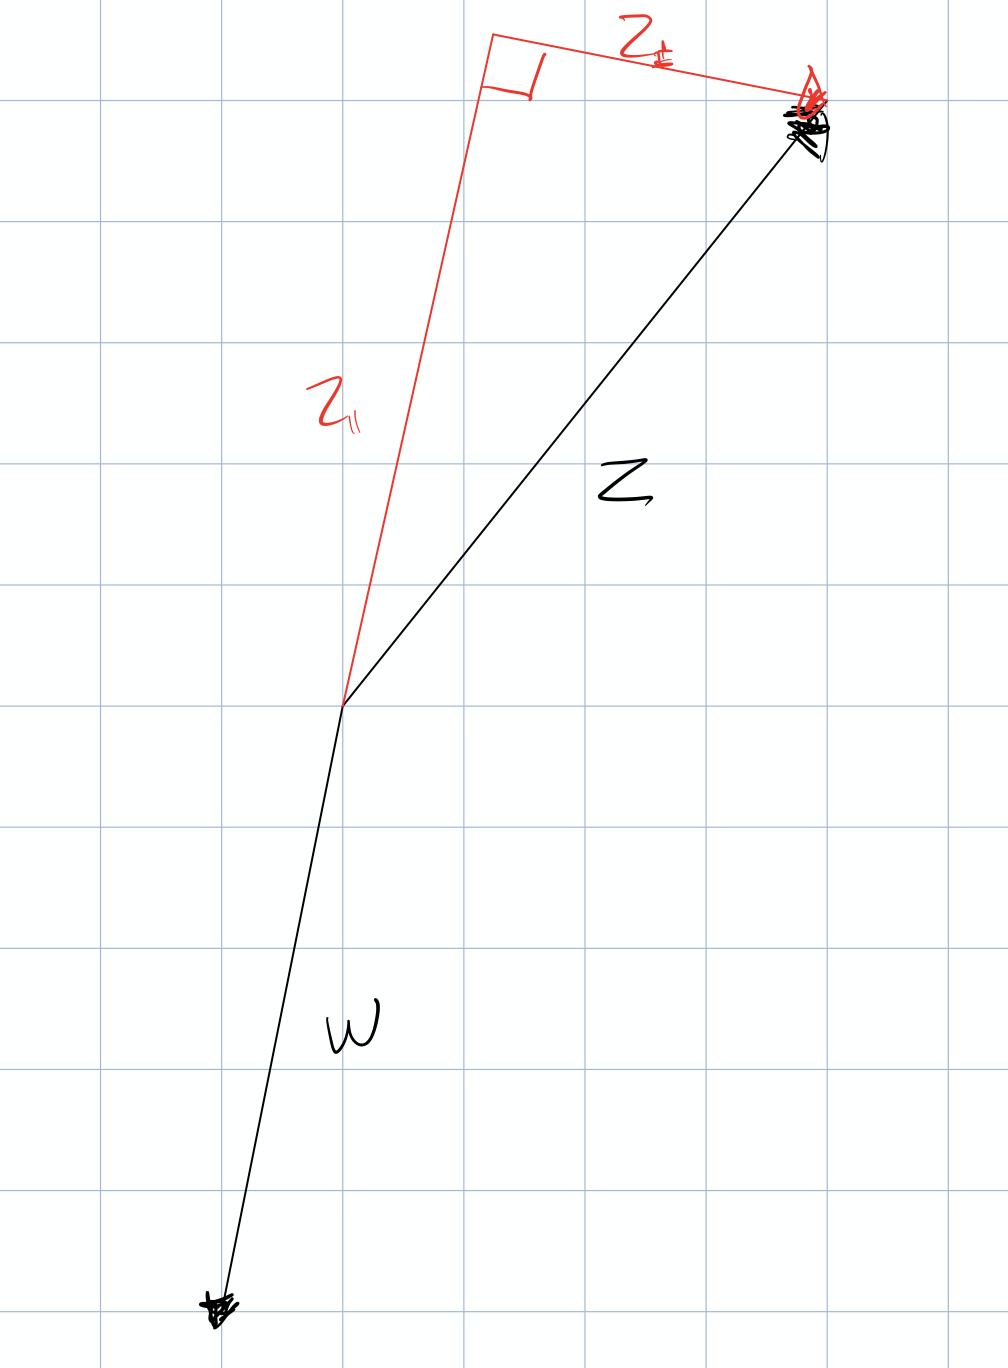

By doing so, and then writing $\mathbf z_{||}$ as a multiple of $\mathbf w$: $\mathbf z_{||} = \alpha \frac{\mathbf w}{\Vert \mathbf w \Vert^2}$ we get the following equation:


$$\mathbf w^T f(\mathbf z) = \alpha + \mathbf w^T \mathbf u h(\alpha + b)$$



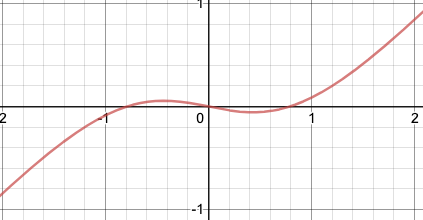

Plotting this for $\mathbf w^T u = -1.2$ we see that the function is not invertible. Solving for $\mathbf w^T \mathbf u$ we get that it should be $\geq -1$.

How do we obtain that? We can instead use a modified vector $$\hat{\mathbf u} = \mathbf u + [m(\mathbf w^T \mathbf u) - \mathbf w^T \mathbf u] \frac{\mathbf w}{\Vert \mathbf w \Vert^2}$$

What dis intuitively does is take $\mathbf u$ and shift it in the direction of $\mathbf w$ such that the dot product is larger than $-1$. The softplus function makes sure that when $\mathbf u$ already points in the direction of $\mathbf w$, we do not scale it (for stability).

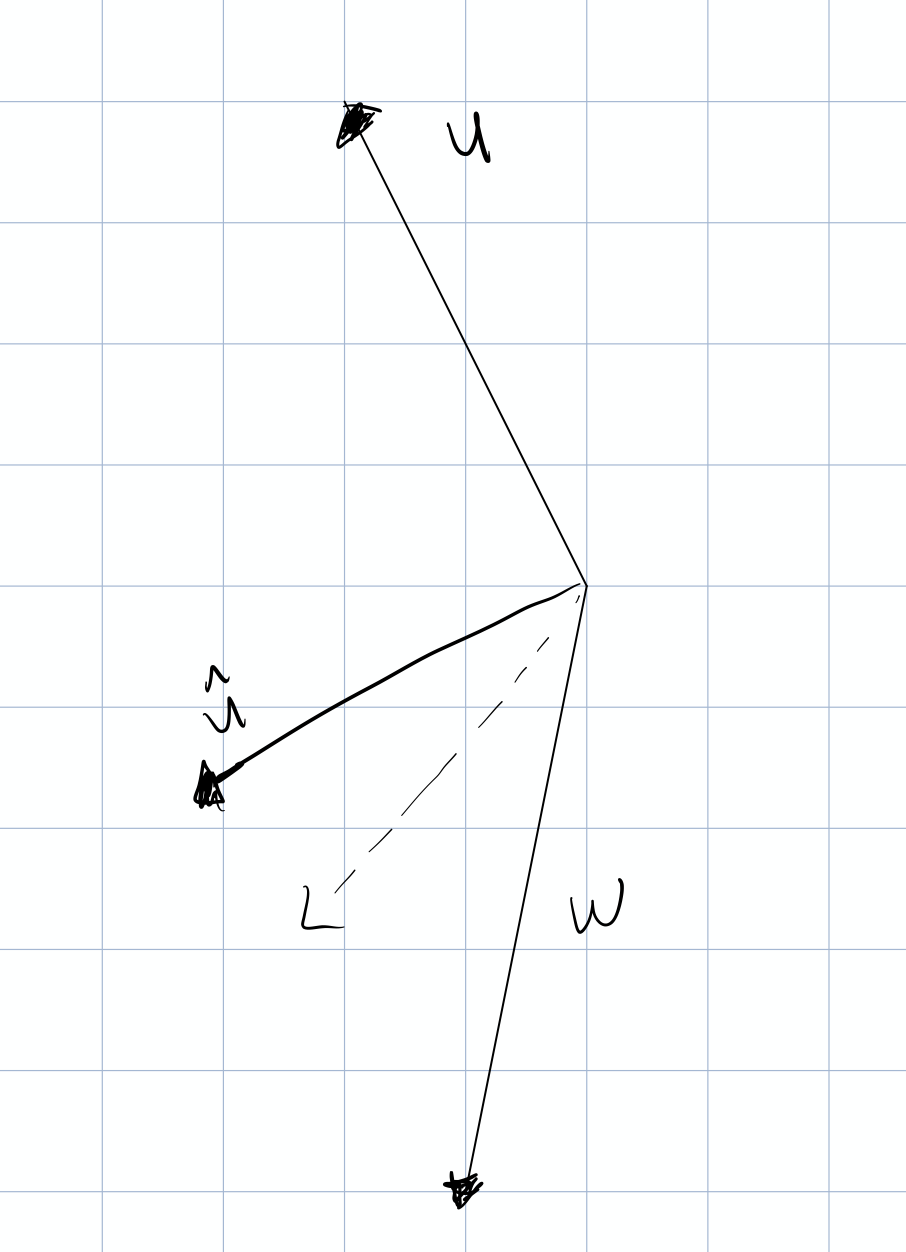

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
import math

# class PlanarFlow(nn.Module):
#     def __init__(self, dim):
#         super(PlanarFlow, self).__init__()
#         self.linear = nn.Linear(dim, 1)
#         self.u = nn.Parameter(torch.randn(1, dim))
        
#         self.h = nn.Tanh()
#         self.h_prime = lambda x: (1 - self.h(x) ** 2)
        
#         self.ljd = None
        
        
#     def forward(self, z):
                
#         wu = self.u @ self.linear.weight.T
        
#         m = -1 + torch.log(1 + torch.exp(wu))

#         u_hat = self.u + (m - wu) * (self.linear.weight / (torch.square(torch.norm(self.linear.weight) + 1e-15)))

#         wz_b = self.h(self.linear(z))
        
#         self.log_jacobian_determinant(wz_b, u_hat)
        

#         return z + u_hat * wz_b
    
#     def log_jacobian_determinant(self, wz_b, u_hat):
              
#         abs_det = torch.abs(1 + u_hat @ self.linear.weight.T * self.h_prime(wz_b))
#         self.ljd = torch.log(abs_det + 1e-15)


In [3]:
class PlanarFlow(nn.Module):

    def __init__(self, data_dim):
        super().__init__()

        self.u = nn.Parameter(torch.rand(data_dim))
        self.w = nn.Parameter(torch.rand(data_dim))
        self.b = nn.Parameter(torch.rand(1))
        self.h = nn.Tanh()
        self.h_prime = lambda z: (1 - self.h(z) ** 2)

    def constrained_u(self):
        """
        Constrain the parameters u to ensure invertibility
        """
        wu = torch.matmul(self.w.T, self.u)
        m = lambda x: -1 + torch.log(1 + torch.exp(x))
        return self.u + (m(wu) - wu) * (self.w / (torch.norm(self.w) ** 2 + 1e-15))

    def forward(self, z):
        u = self.constrained_u()
        hidden_units = torch.matmul(self.w.T, z.T) + self.b
        x = z + u.unsqueeze(0) * self.h(hidden_units).unsqueeze(-1)
        psi = self.h_prime(hidden_units).unsqueeze(0) * self.w.unsqueeze(-1)
        log_det = torch.log((1 + torch.matmul(u.T, psi)).abs() + 1e-15)
        return x, log_det


In [4]:
planarflow = PlanarFlow(4)

In [5]:
planarflow(torch.randn(2, 4))

(tensor([[ 0.0160,  0.0944, -0.0492,  0.8902],
         [-0.7046, -1.3892,  2.1487, -0.4183]], grad_fn=<AddBackward0>),
 tensor([0.2443, 0.3982], grad_fn=<LogBackward>))

The strength of flows is that we can concatenate multiple of these to match highly complex distributions.

In [6]:
class NormalizingFlow(nn.Module):

    def __init__(self, flow_length, dim):
        super().__init__()

        self.layers = nn.Sequential(
            *(PlanarFlow(dim) for _ in range(flow_length)))

    def forward(self, z):
        
        log_jacobians = 0

        for layer in self.layers:
            z, log_jacobian = layer(z)
            log_jacobians += log_jacobian
        return z, log_jacobians



In [7]:
flow = NormalizingFlow(8, 2)

Let's create an energy function that the flow can learn to match.

$$ f_1(\mathbf z) = \frac12 \left( \frac{\Vert \mathbf z \Vert - 2}{0.4} \right)^2 -  \ln\left( \exp \left[ -\frac 12 \left( \frac{z_1 - 2}{0.6} \right)^2 \right] + \exp \left[ -\frac12 \left( \frac{z_1 + 2}{0.6} \right)^2 \right] \right)$$

In [8]:
def f1(z):
    return -((((torch.sqrt(z[:, 0] ** 2 + z[:, 1] ** 2) - 2) / 0.4) ** 2) / 2 - torch.log(
    1e-15 + (torch.exp(-(((z[:, 0] - 2) / 0.6) ** 2) / 2) + torch.exp(-(((z[:, 0] + 2) / 0.6) ** 2) / 2))))


In [9]:
import numpy as np
import matplotlib.pyplot as plt

def plot_exact_density(ax, exact_log_density, lims=np.array([[-4, 4], [-4, 4]]), nb_point_per_dimension=100,
                       cmap="coolwarm", title=None):
    xx, yy = np.meshgrid(np.linspace(lims[0][0], lims[0][1], nb_point_per_dimension),
                         np.linspace(lims[1][0], lims[1][1], nb_point_per_dimension))
    z = torch.tensor(np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1))
    density = torch.exp(exact_log_density(z)).reshape(nb_point_per_dimension, nb_point_per_dimension)
    ax.imshow(density, extent=([lims[0][0], lims[0][1], lims[1][0], lims[1][1]]), cmap=cmap)
    if title is not None:
        plt.title(title, fontsize=22)

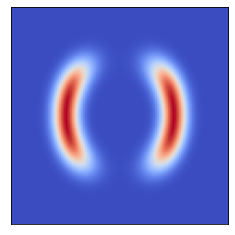

In [10]:
fig, ax = plt.subplots()
plt.xticks([], []); plt.yticks([], [])
plot_exact_density(ax, f1)


In [11]:
def gaussian_log_pdf(z):
    return -.5 * (torch.log(torch.tensor([math.pi * 2], device=z.device)) + z ** 2).sum(1)


In [12]:
import numpy as np
from tqdm import tqdm

In [13]:
device = 'cuda'

In [14]:
def train(flow, optimizer, epochs, log_density, batch_size, data_dim):
    training_loss = 0
    for epoch in tqdm(range(epochs)):
        # Generate new samples from the flow
        z0 = torch.randn(batch_size, data_dim).to(device)
        zk, sum_log_jacobian = flow(z0)

        # Evaluate the exact and approximated densities
#         sum_log_jacobian = sum(layer.ljd for layer in flow.layers).squeeze(-1)        
        flow_log_density = gaussian_log_pdf(z0) - sum_log_jacobian
        
        exact_log_density = log_density(zk).to(device)

        # Compute the loss
        reverse_kl_divergence = (flow_log_density - exact_log_density).mean()
        optimizer.zero_grad()
        loss = reverse_kl_divergence
        loss.backward()
        optimizer.step()

        training_loss += loss.item()
        
        
        if epoch % 100 == 0:
            print(training_loss / (epoch + 1))
        
        
    return training_loss


In [15]:
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-3)
data_dim = 2
flow = flow.to(device)
loss = train(flow, optimizer, 5000, f1, 4096, data_dim)


  0%|          | 10/5000 [00:00<01:51, 44.56it/s]

1.8442846536636353


  2%|▏         | 110/5000 [00:02<01:47, 45.49it/s]

1.100172514372533


  4%|▍         | 210/5000 [00:04<01:43, 46.23it/s]

0.7323402732017621


  6%|▌         | 310/5000 [00:06<01:40, 46.77it/s]

0.4846045204664138


  8%|▊         | 410/5000 [00:08<01:39, 45.98it/s]

0.27605038581002606


 10%|█         | 510/5000 [00:11<01:36, 46.64it/s]

0.09818809538031231


 12%|█▏        | 610/5000 [00:13<01:35, 45.95it/s]

-0.04726454528349261


 14%|█▍        | 710/5000 [00:15<01:32, 46.39it/s]

-0.1706339993850247


 16%|█▌        | 810/5000 [00:17<01:29, 46.90it/s]

-0.27941474900435603


 18%|█▊        | 905/5000 [00:19<01:31, 44.75it/s]

-0.3735075291798147


 20%|██        | 1010/5000 [00:21<01:25, 46.72it/s]

-0.45590231871766435


 22%|██▏       | 1110/5000 [00:23<01:22, 46.98it/s]

-0.5299928908183034


 24%|██▍       | 1210/5000 [00:26<01:21, 46.53it/s]

-0.597575888233872


 26%|██▌       | 1310/5000 [00:28<01:19, 46.35it/s]

-0.6588744911802596


 28%|██▊       | 1410/5000 [00:30<01:15, 47.26it/s]

-0.7139987549767813


 30%|███       | 1510/5000 [00:32<01:13, 47.17it/s]

-0.7634119035919346


 32%|███▏      | 1610/5000 [00:34<01:11, 47.11it/s]

-0.8079836871794923


 34%|███▍      | 1706/5000 [00:36<01:09, 47.34it/s]

-0.8487326329944109


 36%|███▌      | 1806/5000 [00:38<01:07, 47.16it/s]

-0.8859506932085691


 38%|███▊      | 1906/5000 [00:40<01:04, 47.93it/s]

-0.9198896099711871


 40%|████      | 2006/5000 [00:42<01:03, 47.50it/s]

-0.9512908571813514


 42%|████▏     | 2106/5000 [00:45<01:01, 46.83it/s]

-0.9803025762136957


 44%|████▍     | 2206/5000 [00:47<00:59, 46.67it/s]

-1.0073343061443008


 46%|████▌     | 2306/5000 [00:49<00:57, 46.77it/s]

-1.0328007540072612


 48%|████▊     | 2406/5000 [00:51<00:54, 47.29it/s]

-1.0567129256005172


 50%|█████     | 2506/5000 [00:53<00:52, 47.75it/s]

-1.0793246554571245


 52%|█████▏    | 2606/5000 [00:55<00:49, 47.99it/s]

-1.1006326285315844


 54%|█████▍    | 2706/5000 [00:57<00:48, 47.30it/s]

-1.120749183993901


 56%|█████▌    | 2806/5000 [00:59<00:46, 47.25it/s]

-1.1398127007021202


 58%|█████▊    | 2906/5000 [01:02<00:43, 47.66it/s]

-1.1577953447374942


 60%|██████    | 3006/5000 [01:04<00:42, 46.84it/s]

-1.1749851001676088


 62%|██████▏   | 3106/5000 [01:06<00:40, 46.74it/s]

-1.1912702576052163


 64%|██████▍   | 3206/5000 [01:08<00:37, 47.34it/s]

-1.2067290768647023


 66%|██████▌   | 3306/5000 [01:10<00:35, 47.13it/s]

-1.2215490483418467


 68%|██████▊   | 3408/5000 [01:12<00:33, 47.50it/s]

-1.2356607672065316


 70%|███████   | 3508/5000 [01:14<00:32, 46.57it/s]

-1.2491599522550718


 72%|███████▏  | 3608/5000 [01:16<00:29, 47.18it/s]

-1.262109601999235


 74%|███████▍  | 3708/5000 [01:19<00:27, 47.09it/s]

-1.2744428679496513


 76%|███████▌  | 3808/5000 [01:21<00:25, 46.33it/s]

-1.2862328894309438


 78%|███████▊  | 3908/5000 [01:23<00:23, 46.90it/s]

-1.2975698432886782


 80%|████████  | 4008/5000 [01:25<00:21, 46.76it/s]

-1.3083839708747391


 82%|████████▏ | 4108/5000 [01:27<00:19, 46.52it/s]

-1.318773103581541


 84%|████████▍ | 4208/5000 [01:29<00:16, 47.71it/s]

-1.3287250836118454


 86%|████████▌ | 4308/5000 [01:31<00:14, 47.42it/s]

-1.3383321250394555


 88%|████████▊ | 4408/5000 [01:34<00:12, 45.96it/s]

-1.3475223483307843


 90%|█████████ | 4508/5000 [01:36<00:10, 46.34it/s]

-1.3564211042172474


 92%|█████████▏| 4608/5000 [01:38<00:08, 46.59it/s]

-1.3649151406283888


 94%|█████████▍| 4708/5000 [01:40<00:06, 47.34it/s]

-1.3731343403557255


 96%|█████████▌| 4808/5000 [01:42<00:04, 46.91it/s]

-1.3810574307401875


 98%|█████████▊| 4908/5000 [01:44<00:01, 46.32it/s]

-1.3886795259901554


100%|██████████| 5000/5000 [01:46<00:00, 46.91it/s]


In [18]:
def plot_flow_density(flow, ax, lims=np.array([[-4, 4], [-4, 4]]), cmap="coolwarm", title=None,
                      nb_point_per_dimension=1000):
    # Sample broadly from the latent space
    latent_space_boundaries = np.array([[-15, 15], [-15, 15]]);
    xx, yy = np.meshgrid(
        np.linspace(latent_space_boundaries[0][0], latent_space_boundaries[0][1], nb_point_per_dimension),
        np.linspace(latent_space_boundaries[1][0], latent_space_boundaries[1][1], nb_point_per_dimension))
    z = torch.tensor(np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1), dtype=torch.float)
    # Generate data points and evaluate their densities
    zk, sum_log_jacobian = flow(z.to(device))
#     sum_log_jacobian = sum(layer.ljd for layer in flow.layers).squeeze()
    
    final_log_prob = gaussian_log_pdf(z) - sum_log_jacobian.squeeze().cpu()
    qk = torch.exp(final_log_prob)
    
    ax.set_xlim(lims[0][0], lims[0][1]); ax.set_ylim(lims[1][0], lims[1][1])
    ax.pcolormesh(
        zk[:, 0].detach().data.cpu().reshape(nb_point_per_dimension, nb_point_per_dimension),
        zk[:, 1].detach().data.cpu().reshape(nb_point_per_dimension, nb_point_per_dimension) * -1,
        qk.detach().data.reshape(nb_point_per_dimension, nb_point_per_dimension),
        cmap=cmap,
        rasterized=True,
    )
    if title is not None:
        plt.title(title, fontsize=22)


<ipython-input-18-9871f4d815e4>:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(


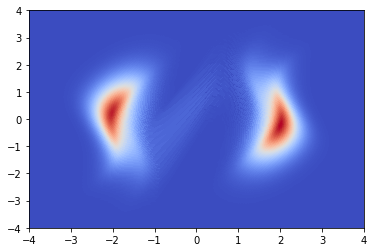

In [19]:
fig, ax = plt.subplots()
plot_flow_density(flow, ax,)
